# Sleep Disorder Detection Using Lifestyle Data

## 1. Importing Necessary Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('../dataset/data.csv')
data.shape

(374, 13)

In [3]:
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
data.drop('Person ID', axis=1, inplace=True)

## 2. Data Preprocessing

### Handling Missing Data

In [5]:
data.isnull().sum()

Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

In [6]:
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('None')

Also, checking for irrelevant values in BMI Category Column

In [7]:
data['BMI Category'].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [8]:
data['BMI Category'] = data['BMI Category'].replace({'Normal Weight': 'Normal'})

In [9]:
data.isnull().sum()

Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

### Descriptive Analysis

In [10]:
data.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


#### Converting Blood Pressure into Systolic BP and Diastolic BP

In [11]:
# Spliting 'Blood Pressure' into 'Systolic' and 'Diastolic'
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True).astype(int)

# Droping the original 'Blood Pressure' column
data = data.drop('Blood Pressure', axis=1)

data.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


### Standardizing Data to Checking for Outliers

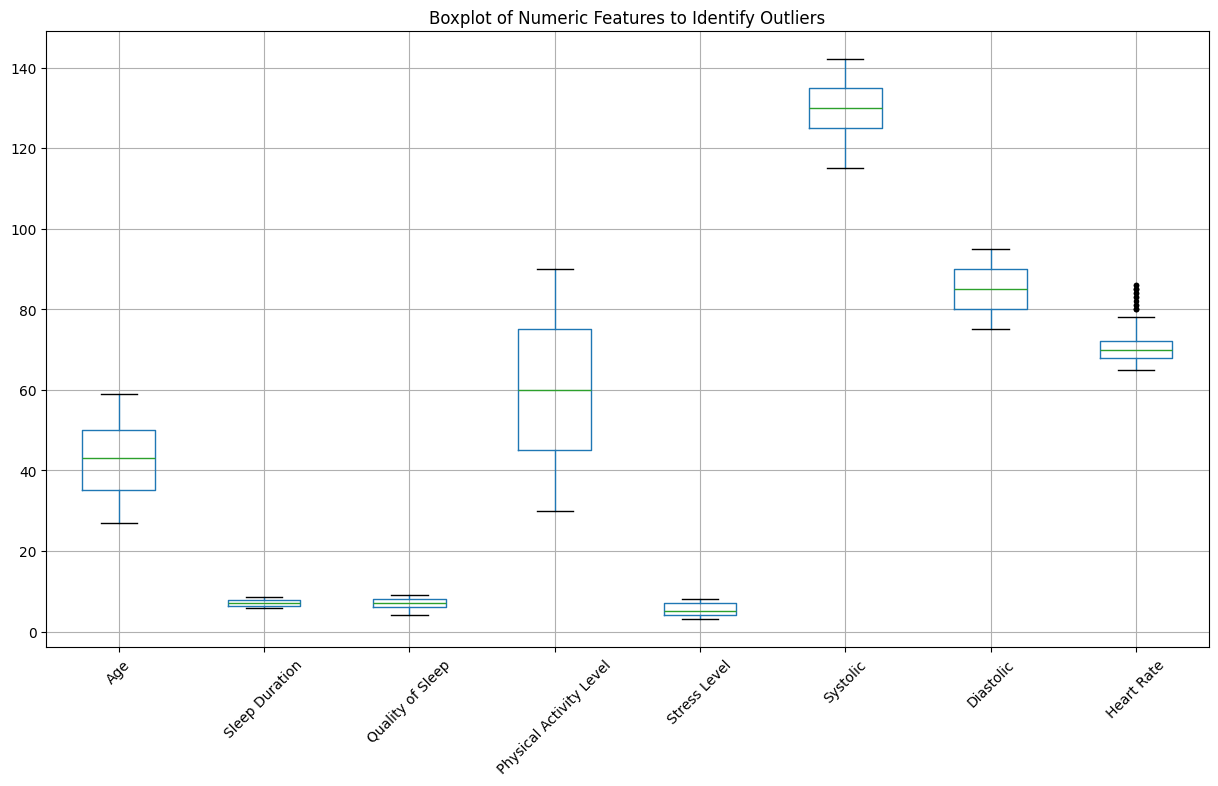

Rows containing outliers:
Empty DataFrame
Columns: [Gender, Age, Occupation, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, BMI Category, Heart Rate, Daily Steps, Sleep Disorder, Systolic, Diastolic]
Index: []


In [12]:
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Systolic', 'Diastolic', 'Heart Rate']

# Box plots to visualize outliers
plt.figure(figsize=(15, 8))
data[numeric_features].boxplot(sym='k.', whis=1.5)
plt.title('Boxplot of Numeric Features to Identify Outliers')
plt.xticks(rotation=45)
plt.show()

# Z-score method for outlier detection
z_scores = zscore(data[numeric_features])
abs_z_scores = abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)

# Printing the rows containing outliers
print("Rows containing outliers:")
print(data[outliers])

### Label Encoding Categorical Varaiables

In [13]:
le_Gender = preprocessing.LabelEncoder()
le_Gender.fit(['Female', 'Male'])
data['Gender'] = le_Gender.transform(data['Gender'])

In [14]:
le_BMI = preprocessing.LabelEncoder()
le_BMI.fit(['Normal', 'Overweight', 'Obese'])
data['BMI Category'] = le_BMI.transform(data['BMI Category'])

In [15]:
le_SD = preprocessing.LabelEncoder()
le_SD.fit(['None', 'Sleep Apnea', 'Insomnia'])
data['Sleep Disorder'] = le_SD.transform(data['Sleep Disorder'])

### Dropping Occupation Column

In [16]:
data.drop('Occupation', axis=1, inplace=True)

## 3. Model Building

### Correlation Matrix

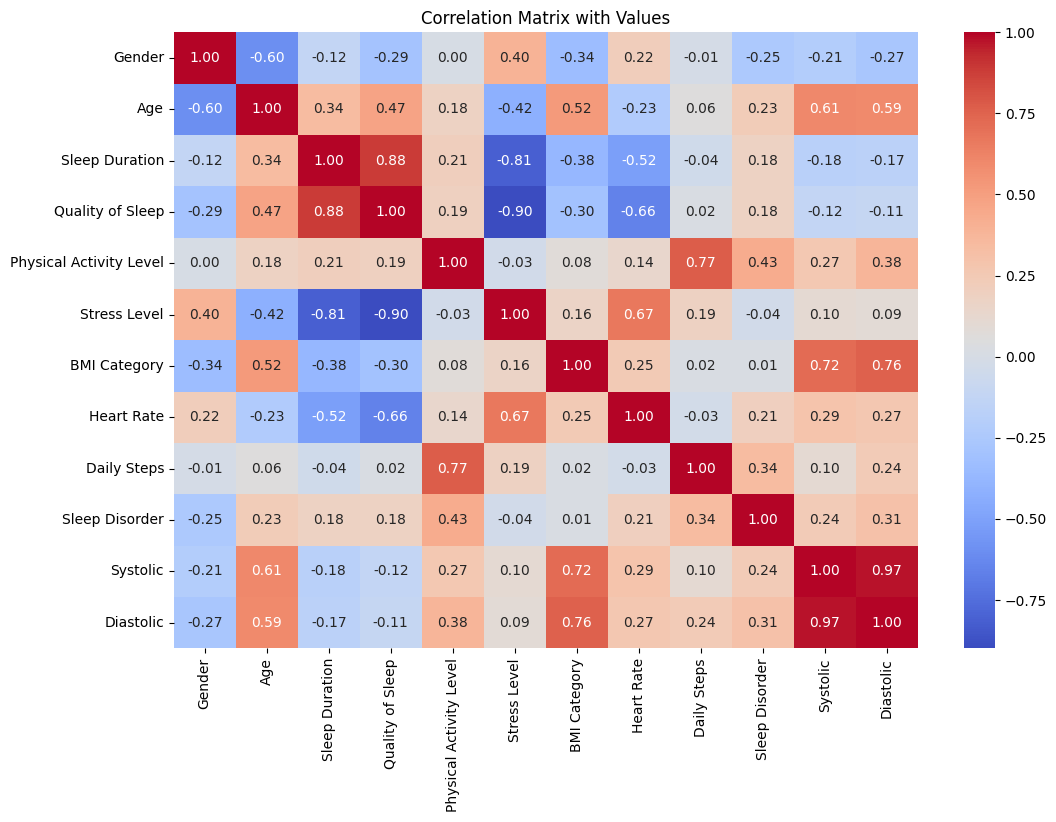

In [17]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Values')
plt.show()

### Extracting Values and Standardizing Values

In [18]:
#Standardizing Values using StandardScaler()
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Standardize the numeric features
scaler = preprocessing.StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [19]:
#Dependent Variables
X = np.asarray(data[['Gender', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']])
X[0:5]

array([[ 1.        , -1.75309569, -1.29888693, -1.09828011, -0.82541823,
         0.34702051,  2.        ,  1.6547187 , -1.61958404, -0.33000229,
        -0.26810236],
       [ 1.        , -1.63764266, -1.17303623, -1.09828011,  0.03984423,
         1.47559156,  0.        ,  1.17047394,  1.97007745, -0.45923879,
        -0.7556402 ],
       [ 1.        , -1.63764266, -1.17303623, -1.09828011,  0.03984423,
         1.47559156,  0.        ,  1.17047394,  1.97007745, -0.45923879,
        -0.7556402 ],
       [ 1.        , -1.63764266, -1.55058833, -2.77142374, -1.40225988,
         1.47559156,  1.        ,  3.5916977 , -2.36227262,  1.47930869,
         0.86948594],
       [ 1.        , -1.63764266, -1.55058833, -2.77142374, -1.40225988,
         1.47559156,  1.        ,  3.5916977 , -2.36227262,  1.47930869,
         0.86948594]])

In [20]:
#Independent Variables
y = np.asarray(data['Sleep Disorder'])
y[0:5]

array([1, 1, 1, 2, 2])

### Splitting dataset into Training and Testing Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (299, 11) (299,)
Test set: (75, 11) (75,)


### Creating Logistic Regression Model with Scikit-Learn

#### Hyperparameter Tuning using GridSearchCV

In [22]:
logreg_model = LogisticRegression(max_iter=10000)

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # Change 'l1' to 'l2'
    'solver': ['lbfgs'],  # Keep only 'lbfgs' solver
}

# Create GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy on Test Set: {accuracy}')

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy on Test Set: 0.8666666666666667


In [23]:
model1 = LogisticRegression(C = 10, penalty = 'l2', solver = 'lbfgs', max_iter = 10000)
model1

LogisticRegression(C=10, max_iter=10000)

In [24]:
#fitting the model

model1.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=10000)

In [25]:
#predicting for both train and test sets
model1pred_train = model1.predict(X_train)
model1pred_test = model1.predict(X_test)

## 4. Model Evaluation

### Accuracy Score

In [26]:
# Accuracy Score

print("LR Model's Accuracy: ", accuracy_score(y_test, model1pred_test))

LR Model's Accuracy:  0.88


### Confusion Matrix

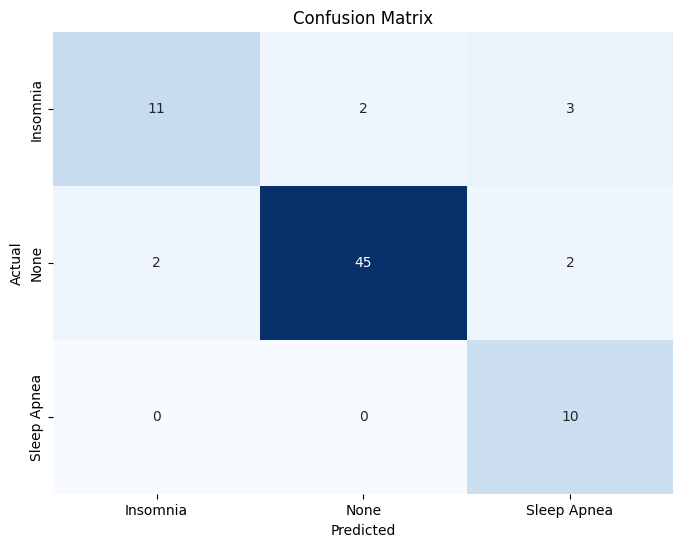

In [27]:
#Confusion Matrix
cm = confusion_matrix(y_test, model1pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Insomnia", "None", "Sleep Apnea"],
            yticklabels=["Insomnia", "None", "Sleep Apnea"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Classification Report

In [28]:
#Classification Report

report1 = classification_report(y_train, model1pred_train)

print("Train Set Classification Report:")
print(report1)

report2 = classification_report(y_test, model1pred_test)

print("Test Set Classification Report:")
print(report2)

Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        61
           1       0.93      0.94      0.94       170
           2       0.90      0.90      0.90        68

    accuracy                           0.91       299
   macro avg       0.90      0.90      0.90       299
weighted avg       0.91      0.91      0.91       299

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.96      0.92      0.94        49
           2       0.67      1.00      0.80        10

    accuracy                           0.88        75
   macro avg       0.82      0.87      0.83        75
weighted avg       0.89      0.88      0.88        75



# End of Notebook